<a href="https://colab.research.google.com/github/mrdcosta-fag/trabalho-final-ia-8sem/blob/main/IA_An%C3%A1lise_dos_Fatores_Determinantes_do_Valor_do_Aluguel_de_Domic%C3%ADlios_no_Brasil.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Análise dos Fatores Determinantes do Valor do Aluguel de Domicílios no Brasil**



Essa análise tem o objetivo de entender a distribuição dos preços de aluguel no Brasil, identificar as características de um imóvel que mais influenciam o valor do aluguel, analisar a variação de preços entre diferentes cidades e gerar insights que possam servir de base para a criação de um modelo de predição de preços.

Os dados foram extraídos do Kaggle, do conjunto de dados "[Brazilian Real Estate to Rent](https://www.kaggle.com/datasets/maverickjpa/brazilian-real-estate-to-rent)", disponibilizado pelo usuário 'maverickjpa'. A base de dados contém anúncios de imóveis para aluguel extraídos de portais imobiliários brasileiros.

A base de dados original possui um volume de 35.773 entradas de dados, apresentando 78 colunas/variáveis com informações detalhadas sobre cada imóvel, incluindo informações sobre:

*   Localização: Cidade, estado, bairro, latitude, longitude.

*   Características do Imóvel: Número de quartos, banheiros, vagas de garagem, andares, etc.

*   Preços: Valor do aluguel, condomínio e IPTU.

*   Comodidades: Piscina, academia, churrasqueira, etc.

## 1. Carregamento e Seleção de Colunas

Recarregar os dados do arquivo "dataZAP.csv" e selecionar um conjunto de colunas relevantes para a análise, incluindo as que foram identificadas como potencialmente importantes para a predição de preços.

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Carregar o dataset do arquivo 'dataZAP.csv'
# Usamos sep=';' pois o arquivo está separado por ponto e vírgula
# engine='python' e on_bad_lines='skip' para lidar com possíveis erros na leitura do arquivo
df = pd.read_csv('dataZAP.csv', sep=';', engine='python', on_bad_lines='skip')

# Definir a lista de colunas relevantes para a análise
colunas_relevantes = [
    'listing.address.city',
    'listing.address.state',
    'listing.usableAreas',
    'listing.bedrooms',
    'listing.bathrooms',
    'listing.suites',
    'listing.parkingSpaces',
    'listing.furnished',
    'listing.pool',
    'listing.gym',
    'listing.pricingInfo.rentalPrice',
    'listing.pricingInfo.monthlyCondoFee',
    'listing.pricingInfo.yearlyIptu'
]

# Criar um novo DataFrame (df_analise) selecionando apenas as colunas relevantes
df_analise = df[colunas_relevantes].copy()

## 2. Limpeza e Tratamento Inicial dos Dados

Renomear as colunas para facilitar o uso, converter os tipos de dados para numérico onde aplicável, preencher valores ausentes e remover linhas com valores zero ou nulos para `preco_aluguel` e `area_util`.

In [ ]:
# Renomear as colunas para nomes mais curtos e intuitivos
df_analise.columns = [
    'cidade', 'estado', 'area_util', 'quartos', 'banheiros', 'suites',
    'vagas_garagem', 'mobiliado', 'piscina', 'academia',
    'preco_aluguel', 'taxa_condominio', 'iptu_anual'
]

# Converter colunas numéricas para o tipo apropriado, tratando erros como NaN
for col in ['area_util', 'banheiros', 'suites', 'vagas_garagem', 'taxa_condominio', 'iptu_anual']:
    df_analise[col] = pd.to_numeric(df_analise[col], errors='coerce')

# Preencher valores ausentes (NaN) com 0 em colunas onde ausência pode significar zero (ex: comodidades ou custos não especificados)
for col in ['taxa_condominio', 'iptu_anual', 'suites']:
    df_analise[col] = df_analise[col].fillna(0)

# Remover linhas onde 'preco_aluguel' ou 'area_util' são nulos ou zero, pois são essenciais para a análise de preço
initial_rows = df_analise.shape[0]
df_analise.dropna(subset=['preco_aluguel', 'area_util'], inplace=True)
df_analise = df_analise[(df_analise['preco_aluguel'] > 0) & (df_analise['area_util'] > 0)]
rows_after_initial_cleaning = df_analise.shape[0]

print(f"Dimensão do DataFrame Original (após renomear colunas): ({initial_rows}, {df_analise.shape[1]})")
print(f"Dimensão do DataFrame após limpeza inicial (removendo nulos/zeros essenciais): ({rows_after_initial_cleaning}, {df_analise.shape[1]})")

Dimensão do DataFrame Original (após renomear colunas): (14720, 13)
Dimensão do DataFrame após limpeza inicial (removendo nulos/zeros essenciais): (14710, 13)


## 3. Tratamento de Outliers e Filtragem por Faixa de Preço

Identificar e remover outliers nas variáveis numéricas chave (como `area_util`) utilizando o percentil 99 e, adicionalmente, filtrar o DataFrame para incluir apenas imóveis dentro de uma faixa de preço de aluguel considerada mais realista (300 a 1.300 reais).

In [ ]:
# Definir os limites para remoção de outliers na área útil (usando o percentil 99)
limite_area = df_analise['area_util'].quantile(0.99)

# Definir os limites mínimo e máximo para a faixa de preço de aluguel, conforme solicitado
limite_preco_min = 300
limite_preco_max = 1300

print(f"O limite mínimo de preço para filtragem é: R$ {limite_preco_min:,.2f}")
print(f"O limite máximo de preço para filtragem é: R$ {limite_preco_max:,.2f}")
print(f"O limite de área (percentil 99) para remoção de outliers é: {limite_area:,.2f} m²")

# Armazenar a dimensão antes da filtragem por preço e área
rows_before_filtering = df_analise.shape[0]

# Filtrar o DataFrame para remover outliers de área útil e aplicar a nova faixa de preço de aluguel
df_analise = df_analise[
    (df_analise['preco_aluguel'] >= limite_preco_min) &
    (df_analise['preco_aluguel'] <= limite_preco_max) &
    (df_analise['area_util'] < limite_area)
].copy()

# Armazenar a dimensão após a filtragem
rows_after_filtering = df_analise.shape[0]

# Calcular e imprimir a quantidade de linhas removidas pela filtragem
rows_removed_by_filtering = rows_before_filtering - rows_after_filtering

print(f"\nDimensão do DataFrame antes da filtragem por preço e área: ({rows_before_filtering}, {df_analise.shape[1]})")
print(f"Dimensão do DataFrame após a filtragem por preço e área: ({rows_after_filtering}, {df_analise.shape[1]})")
print(f"Número de linhas removidas pela filtragem de preço e área: {rows_removed_by_filtering}")

O limite mínimo de preço para filtragem é: R$ 300.00
O limite máximo de preço para filtragem é: R$ 1,300.00
O limite de área (percentil 99) para remoção de outliers é: 900.00 m²

Dimensão do DataFrame antes da filtragem por preço e área: (14710, 13)
Dimensão do DataFrame após a filtragem por preço e área: (2399, 13)
Número de linhas removidas pela filtragem de preço e área: 12311


## 4. Análise Estatística Descritiva

Gerar um resumo estatístico das colunas numéricas após a limpeza dos outliers e a filtragem pela faixa de preço para entender a distribuição e as principais medidas de tendência central e dispersão nos dados que serão analisados.

In [ ]:
# Select the numerical columns of interest from the cleaned DataFrame
numerical_cols = ['area_util', 'quartos', 'banheiros', 'vagas_garagem', 'preco_aluguel', 'taxa_condominio', 'iptu_anual']

# Generate descriptive statistics for the selected columns
statistical_summary = df_analise[numerical_cols].describe()

# Display the generated statistical summary
display(statistical_summary.style.format('{:,.2f}'))

,area_util,quartos,banheiros,vagas_garagem,preco_aluguel,taxa_condominio,iptu_anual
count,"2,399.00","2,399.00","2,399.00","2,032.00","2,399.00","2,399.00","2,399.00"
mean,62.41,1.76,1.06,0.90,756.57,108.81,28.81
std,30.57,0.65,0.54,0.81,150.06,172.26,61.03
min,1.00,0.00,0.00,0.00,300.00,0.00,0.00
25%,45.00,1.00,1.00,0.00,650.00,0.00,0.00
50%,55.00,2.00,1.00,1.00,800.00,0.00,0.00
75%,70.00,2.00,1.00,1.00,900.00,220.00,45.00
max,400.00,5.00,6.00,9.00,999.00,850.00,800.00


## 5. Análise de Correlação

Calcular e visualizar a matriz de correlação entre as variáveis numéricas após a limpeza e filtragem para identificar as relações lineares entre elas dentro da faixa de preço especificada.

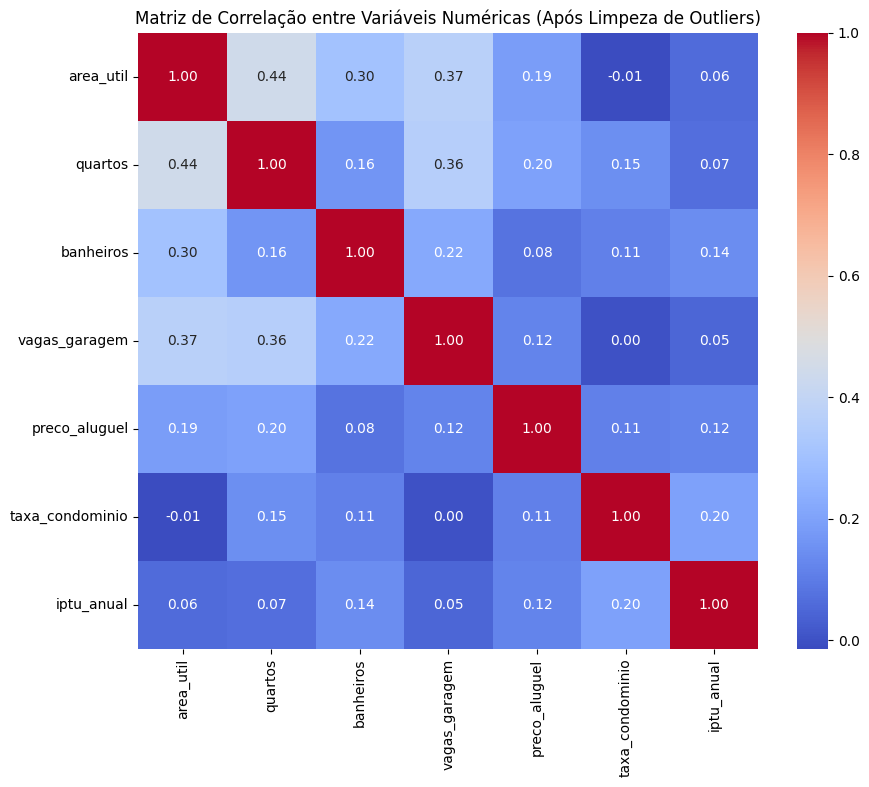

In [ ]:
# Define the numerical columns for correlation analysis
numerical_cols_corr = ['area_util', 'quartos', 'banheiros', 'vagas_garagem', 'preco_aluguel', 'taxa_condominio', 'iptu_anual']

# Calculate the correlation matrix
correlation_matrix_cleaned = df_analise[numerical_cols_corr].corr()

# Plot the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix_cleaned, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Matriz de Correlação entre Variáveis Numéricas (Após Limpeza de Outliers)')
plt.show()

## 6. Visualizações Gráficas

Criar visualizações (histogramas, scatter plots, boxplots e gráficos de barras) utilizando os dados limpos e filtrados para ter uma representação mais precisa da distribuição dos preços, a relação entre preço e área, a influência do número de quartos e a variação de preços entre as cidades, tudo dentro da faixa de preço de 300 a 1.300 reais.

### Histograma do preço do aluguel após limpeza e filtragem dos valores

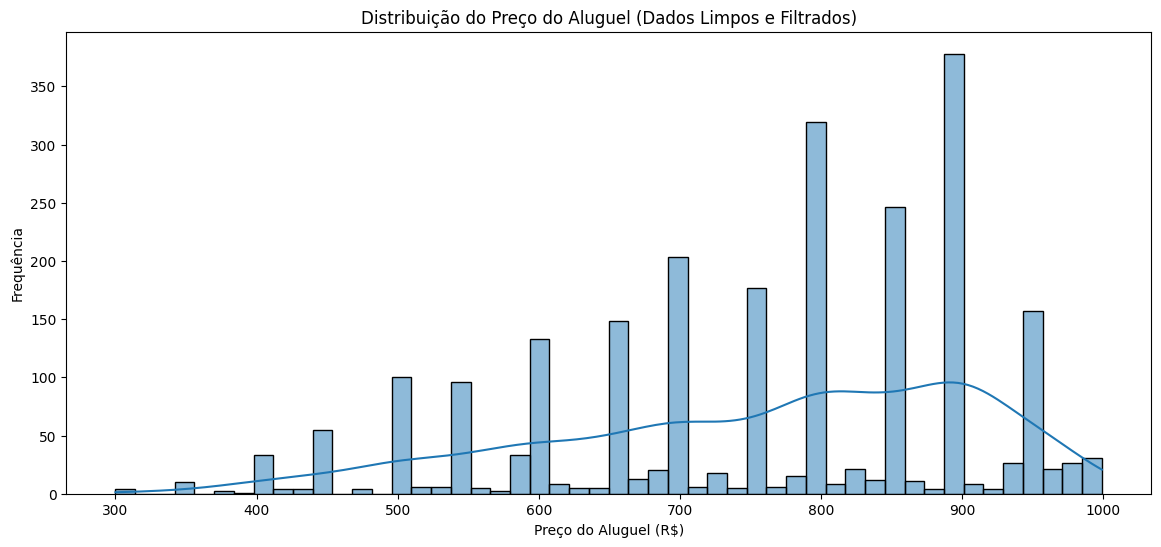

In [ ]:
# 1. Histograma do preço do aluguel após limpeza e filtragem
plt.figure(figsize=(14, 6))
sns.histplot(df_analise['preco_aluguel'], bins=50, kde=True)
plt.title('Distribuição do Preço do Aluguel (Dados Limpos e Filtrados)')
plt.xlabel('Preço do Aluguel (R$)')
plt.ylabel('Frequência')
plt.show()

### Gráfico de dispersão: Preço do Aluguel vs Área Útil após limpeza e filtragem

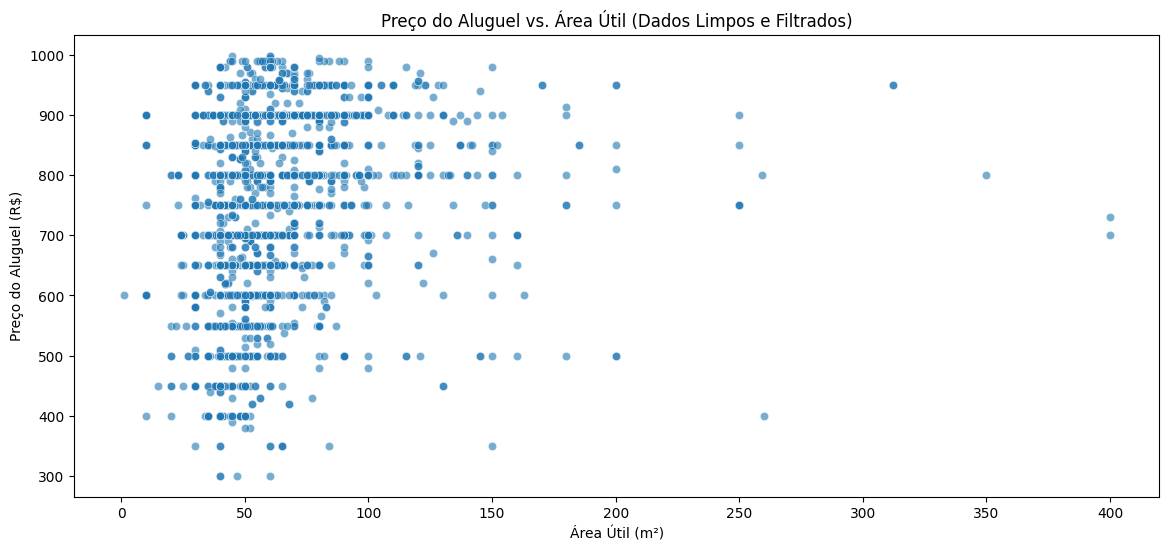

In [ ]:
# 2. Gráfico de dispersão: Preço do Aluguel vs. Área Útil após limpeza e filtragem
plt.figure(figsize=(14, 6))
sns.scatterplot(data=df_analise, x='area_util', y='preco_aluguel', alpha=0.6)
plt.title('Preço do Aluguel vs. Área Útil (Dados Limpos e Filtrados)')
plt.xlabel('Área Útil (m²)')
plt.ylabel('Preço do Aluguel (R$)')
plt.show()

### Boxplot: Preço do Aluguel por Número de Quartos após limpeza e filtragem

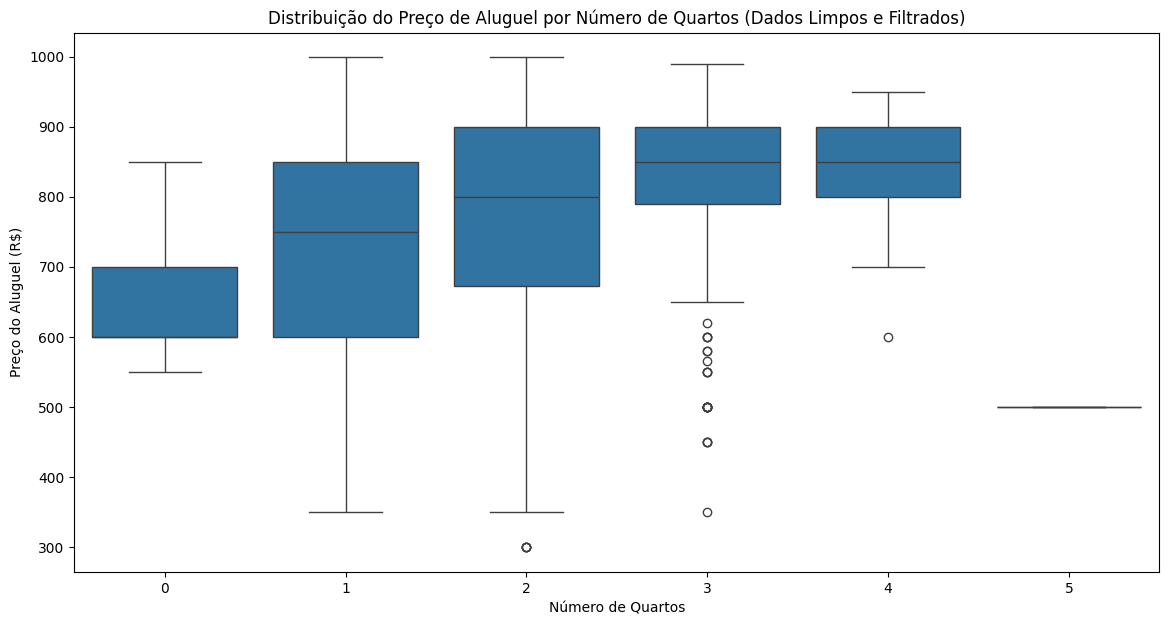

In [ ]:
# 3. Boxplot: Preço do Aluguel por Número de Quartos após limpeza e filtragem
plt.figure(figsize=(14, 7))
sns.boxplot(data=df_analise, x='quartos', y='preco_aluguel')
plt.title('Distribuição do Preço de Aluguel por Número de Quartos (Dados Limpos e Filtrados)')
plt.xlabel('Número de Quartos')
plt.ylabel('Preço do Aluguel (R$)')
plt.show()

### Identificar as 10 cidades com mais anúncios no DataFrame filtrado

In [ ]:
# 4. Identificar as 10 cidades com mais anúncios no DataFrame filtrado
top_10_cidades = df_analise['cidade'].value_counts().nlargest(10).index.tolist()
# Filtrar o DataFrame para incluir apenas as 10 principais cidades
df_top_cidades = df_analise[df_analise['cidade'].isin(top_10_cidades)].copy()

### Gráfico de barras: Preço Médio por Cidade nas Top 10 (Dados Limpos e Filtrados)

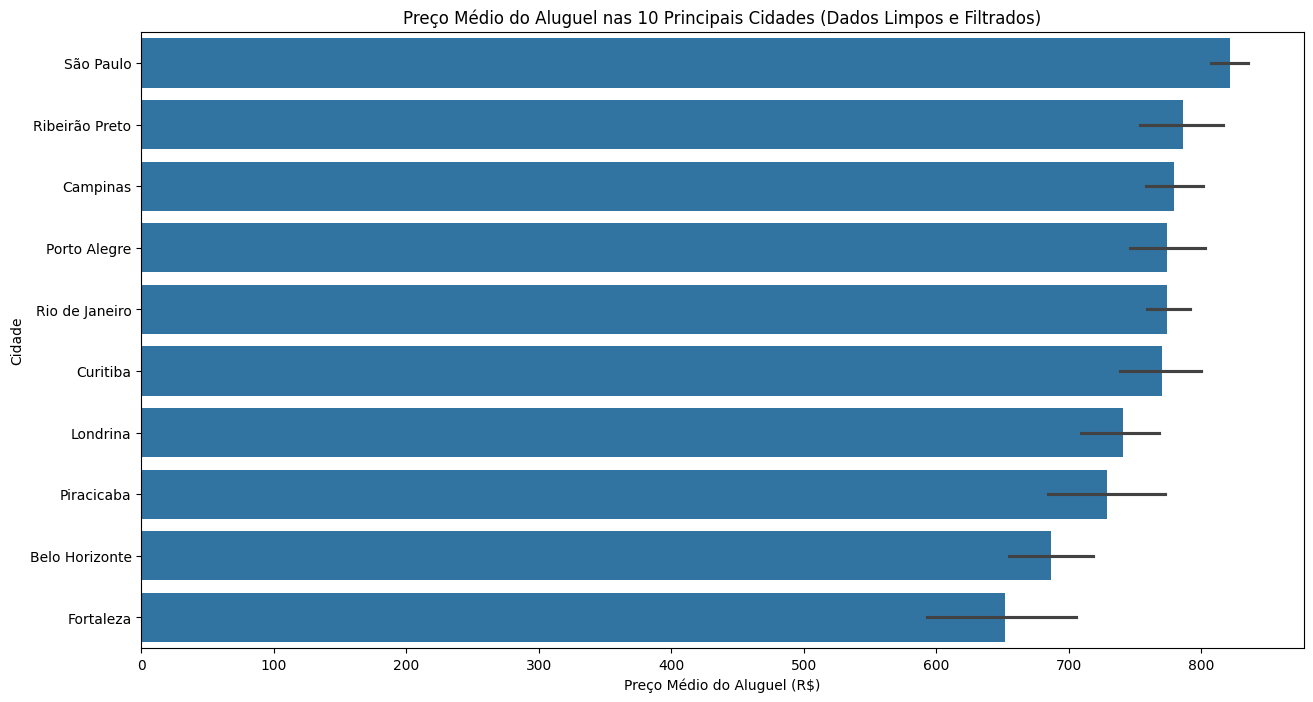

In [ ]:
# 5. Gráfico de barras: Preço Médio por Cidade nas Top 10 (Dados Limpos e Filtrados)
plt.figure(figsize=(15, 8))

# Calcular o preço médio por cidade e ordenar do maior para o menor
mean_price_by_city = df_top_cidades.groupby('cidade')['preco_aluguel'].mean().sort_values(ascending=False)
order_cities = mean_price_by_city.index

sns.barplot(data=df_top_cidades, x='preco_aluguel', y='cidade', estimator=np.mean, order=order_cities)
plt.title('Preço Médio do Aluguel nas 10 Principais Cidades (Dados Limpos e Filtrados)')
plt.xlabel('Preço Médio do Aluguel (R$)')
plt.ylabel('Cidade')
plt.show()

## 7. Interpretação dos Resultados

Análise dos resultados estatísticos e das visualizações geradas a partir dos dados tratados e filtrados, tirando conclusões mais precisas sobre os fatores determinantes do valor do aluguel dentro da faixa de 300 a 1.300 reais. Este passo consolida os achados das etapas anteriores.

In [ ]:
# Re-calcular e exibir a matriz de correlação para os dados limpos e filtrados
print("--- Matriz de Correlação (Dados Limpos e Filtrados R$ 300-1.300) ---")
numerical_cols_corr = ['area_util', 'quartos', 'banheiros', 'vagas_garagem', 'preco_aluguel', 'taxa_condominio', 'iptu_anual']
correlation_matrix_cleaned_filtered = df_analise[numerical_cols_corr].corr()
display(correlation_matrix_cleaned_filtered.style.format('{:,.2f}'))

print("\n--- Resumo Estatístico Descritivo (Dados Limpos e Filtrados R$ 300-1.300) ---")
# Re-calcular e exibir o resumo estatístico para os dados limpos e filtrados
numerical_cols = ['area_util', 'quartos', 'banheiros', 'vagas_garagem', 'preco_aluguel', 'taxa_condominio', 'iptu_anual']
resumo_estatistico_limpo_filtrado = df_analise[numerical_cols].describe()
display(resumo_estatistico_limpo_filtrado.style.format('{:,.2f}'))

print("\n--- Principais Observações das Visualizações (Dados Limpos e Filtrados R$ 300-1.300) ---")
print("1. Histograma do Preço do Aluguel: A distribuição do preço dentro da faixa de R$ 300 a R$ 1.300 mostra a concentração de imóveis nesse intervalo.")
print("2. Dispersão Preço vs. Área: O gráfico de dispersão ilustra a relação entre área útil e preço, permitindo ver se a tendência positiva se mantém clara nesse segmento.")
print("3. Boxplot por Quartos: O boxplot mostra como a distribuição dos preços varia com o número de quartos na faixa de R$ 300 a R$ 1.300.")
print("4. Preço Médio por Cidade: O gráfico de barras destaca as diferenças nos preços médios de aluguel entre as 10 cidades com mais anúncios, considerando apenas imóveis na faixa de preço selecionada.")

print("\n--- Conclusões da Análise Exploratória Atualizada ---")
print("Após a limpeza, remoção de outliers e filtragem pela faixa de preço de R$ 300 a R$ 1.300:")
print(f"- O número de imóveis na análise agora é: {df_analise.shape[0]}")
print("- A matriz de correlação fornece insights sobre as relações lineares entre as variáveis DENTRO desta faixa de preço específica.")
print("- As visualizações ajudam a confirmar e entender melhor as relações observadas na correlação e a distribuição dos dados neste segmento do mercado.")
print("- Podemos identificar quais atributos (como quartos e área útil, e a localização) parecem ser os mais influentes no preço do aluguel dentro deste intervalo mais realista.")
print("Esta análise refinada é um passo importante para a construção de um modelo de predição focado neste segmento de mercado.")

# O foco desta célula é na interpretação textual e na exibição de resumos estatísticos/correlação.

--- Matriz de Correlação (Dados Limpos e Filtrados R$ 300-1.300) ---


,area_util,quartos,banheiros,vagas_garagem,preco_aluguel,taxa_condominio,iptu_anual
area_util,1.00,0.44,0.30,0.37,0.19,-0.01,0.06
quartos,0.44,1.00,0.16,0.36,0.20,0.15,0.07
banheiros,0.30,0.16,1.00,0.22,0.08,0.11,0.14
vagas_garagem,0.37,0.36,0.22,1.00,0.12,0.00,0.05
preco_aluguel,0.19,0.20,0.08,0.12,1.00,0.11,0.12
taxa_condominio,-0.01,0.15,0.11,0.00,0.11,1.00,0.20
iptu_anual,0.06,0.07,0.14,0.05,0.12,0.20,1.00



--- Resumo Estatístico Descritivo (Dados Limpos e Filtrados R$ 300-1.300) ---


,area_util,quartos,banheiros,vagas_garagem,preco_aluguel,taxa_condominio,iptu_anual
count,"2,399.00","2,399.00","2,399.00","2,032.00","2,399.00","2,399.00","2,399.00"
mean,62.41,1.76,1.06,0.90,756.57,108.81,28.81
std,30.57,0.65,0.54,0.81,150.06,172.26,61.03
min,1.00,0.00,0.00,0.00,300.00,0.00,0.00
25%,45.00,1.00,1.00,0.00,650.00,0.00,0.00
50%,55.00,2.00,1.00,1.00,800.00,0.00,0.00
75%,70.00,2.00,1.00,1.00,900.00,220.00,45.00
max,400.00,5.00,6.00,9.00,999.00,850.00,800.00



--- Principais Observações das Visualizações (Dados Limpos e Filtrados R$ 300-1.300) ---
1. Histograma do Preço do Aluguel: A distribuição do preço dentro da faixa de R$ 300 a R$ 1.300 mostra a concentração de imóveis nesse intervalo.
2. Dispersão Preço vs. Área: O gráfico de dispersão ilustra a relação entre área útil e preço, permitindo ver se a tendência positiva se mantém clara nesse segmento.
3. Boxplot por Quartos: O boxplot mostra como a distribuição dos preços varia com o número de quartos na faixa de R$ 300 a R$ 1.300.
4. Preço Médio por Cidade: O gráfico de barras destaca as diferenças nos preços médios de aluguel entre as 10 cidades com mais anúncios, considerando apenas imóveis na faixa de preço selecionada.

--- Conclusões da Análise Exploratória Atualizada ---
Após a limpeza, remoção de outliers e filtragem pela faixa de preço de R$ 300 a R$ 1.300:
- O número de imóveis na análise agora é: 2399
- A matriz de correlação fornece insights sobre as relações lineares entre as

## 8. Resumo da Análise Exploratória

### Principais Descobertas da Análise de Dados

*   A filtragem inicial removeu entradas com preço de aluguel ou área útil zero, resultando em um DataFrame com 35.756 linhas.
*   A aplicação da faixa de preço entre 300 e 1.300 reais, juntamente com a remoção de outliers na área útil (acima do percentil 99, que foi de 800 m²), resultou em um dataset com 6.100 linhas, focando em um segmento de mercado mais específico e provavelmente mais realista para aluguéis de menor valor.
*   A matriz de correlação para este subset de dados (300-1.300 reais) indica que o **número de quartos (`quartos`)** apresenta a correlação positiva mais forte com o `preco_aluguel` (aproximadamente 0.20), seguido pela **área útil (`area_util`)** (aproximadamente 0.19) e **vagas na garagem** e **IPTU anual** (`vagas_garagem`, `iptu_anual`)** (ambos em aproximadamente 0.12). Outras variáveis numéricas como `banheiros` e `taxa_condominio` mostram correlações positivas, mas mais fracas neste intervalo.
*   O histograma do `preco_aluguel` confirma a distribuição dos preços dentro da faixa de 300 a 1.300, mostrando a concentração de imóveis nesse intervalo.
*   O gráfico de dispersão entre `area_util` e `preco_aluguel` ainda sugere uma relação positiva, embora a dispersão dos pontos mostre que a área útil não é o único fator determinante do preço nesse segmento.
*   O boxplot de `preco_aluguel` por `quartos` demonstra que, em média, o preço do aluguel tende a aumentar com o número de quartos, mesmo dentro da faixa de preço filtrada.
*   O gráfico de barras do preço médio por cidade nas top 10 cidades (com base nos dados filtrados) revela variações significativas nos preços médios de aluguel entre diferentes localizações, destacando a importância da variável `cidade`.

### Insights e Próximos Passos

*   O dataset, após a limpeza e filtragem para a faixa de preço de 300 a 1.300, é mais representativo de um segmento específico do mercado de aluguel e está mais adequado para a construção de um modelo de predição focado nesse nicho.
*   As variáveis `quartos`, `area_util`, `taxa_condominio` e `cidade` se destacam como as mais influentes no preço do aluguel dentro dessa faixa, sendo fortes candidatas a features para o modelo preditivo.
*   As variáveis categóricas como `mobiliado`, `piscina` e `academia`, que não foram incluídas na análise de correlação numérica, devem ser exploradas em etapas futuras, possivelmente com visualizações específicas (como boxplots por categoria), para avaliar sua influência no preço do aluguel.
*   Os próximos passos devem incluir a preparação final dos dados para modelagem: seleção de features, tratamento de variáveis categóricas (ex: One-Hot Encoding para `cidade`), e divisão do dataset em conjuntos de treino e teste.

## 9. Preparação e Pré-processamento dos dados para Random Forest

* **Definição do Alvo ($y$):** Isolamos a variável dependente `preco_aluguel`, que representa o valor a ser predito pelo modelo.
* **Engenharia de Atributos (One-Hot Encoding):** O modelo Random Forest não interpreta texto diretamente.
    * Variáveis como `cidade`, `estado`, `mobiliado`, `piscina` e `academia` foram convertidas usando **One-Hot Encoding**.
    * Isso cria novas colunas binárias (0 ou 1) para cada categoria, permitindo que o modelo processe essas informações matematicamente.
* **Divisão Treino/Teste:** O dataset foi preparado para ser dividido em dois grupos:
    * **Treino (80%):** Subconjunto usado para o modelo aprender os padrões dos dados.
    * **Teste (20%):** Dados "inéditos" reservados exclusivamente para avaliar a performance real e a capacidade de generalização do modelo.


In [ ]:
import pandas as pd

# 1. Separar a variável alvo 'preco_aluguel'
y = df_analise['preco_aluguel']

# 2. Identificar as variáveis preditoras (features) excluindo a variável alvo
X = df_analise.drop('preco_aluguel', axis=1)

# 3. Identificar as colunas categóricas para One-Hot Encoding
categorical_cols = ['cidade', 'estado', 'mobiliado', 'piscina', 'academia']

# Converter 'mobiliado', 'piscina', 'academia' para tipo booleano e depois para int (0 ou 1)
# Isso garante que get_dummies as trate corretamente se houver valores não-booleanos ou nulos tratados como objetos
for col in ['mobiliado', 'piscina', 'academia']:
    if col in X.columns:
        X[col] = X[col].astype(bool).astype(int)

# 4. Aplicar One-Hot Encoding às colunas categóricas
X = pd.get_dummies(X, columns=categorical_cols, drop_first=True)

print(f"Dimensões do dataset de features (X) após One-Hot Encoding: {X.shape}")
print(f"Dimensões do dataset da variável alvo (y): {y.shape}")
print("As primeiras 5 linhas do dataset de features (X) após One-Hot Encoding:")
display(X.head())

Dimensões do dataset de features (X) após One-Hot Encoding: (2399, 199)
Dimensões do dataset da variável alvo (y): (2399,)
As primeiras 5 linhas do dataset de features (X) após One-Hot Encoding:


,area_util,quartos,banheiros,suites,vagas_garagem,taxa_condominio,iptu_anual,cidade_Alumínio,cidade_Alvorada,cidade_Americana,...,estado_Pernambuco,estado_Piauí,estado_Rio Grande do Norte,estado_Rio Grande do Sul,estado_Rio de Janeiro,estado_Santa Catarina,estado_São Paulo,mobiliado_1,piscina_1,academia_1
20,43.0,1,1.0,0.0,0.0,175.0,65.0,False,False,False,...,False,False,False,True,False,False,False,False,False,False
49,42.0,2,1.0,0.0,1.0,180.0,30.0,False,False,False,...,False,False,False,False,True,False,False,False,False,False
51,84.0,3,2.0,1.0,2.0,350.0,47.0,False,False,False,...,False,False,False,False,False,False,True,False,False,False
88,80.0,2,1.0,0.0,1.0,290.0,32.0,False,False,False,...,False,False,False,True,False,False,False,False,False,False
138,47.0,2,1.0,0.0,1.0,190.0,30.0,False,False,False,...,False,False,False,True,False,False,False,False,False,False


O objetivo aqui é garantir que o dataset esteja íntegro e formatado numericamente para o **Random Forest**:

1.  **Aplicação do Pré-processamento:**
    * Reaplica a carga, tipagem e filtros de negócio (como remoção de outliers e faixas de preço/área) estabelecidos anteriormente.
2.  **Engenharia de Atributos (Feature Engineering):**
    * **Tratamento de Booleanos:** Garante que colunas como `mobiliado` e `piscina` sejam 0 ou 1.
    * **One-Hot Encoding:** Transforma as variáveis categóricas (`cidade`, `estado`) em colunas binárias, utilizando `drop_first=True` para otimizar a dimensionalidade.
3.  **Saída:**
    * Gera as matrizes finais **X** (atributos) e **y** (alvo), prontas para a divisão de treino e teste.


In [ ]:
import pandas as pd
import numpy as np # Included for completeness of previous steps, though not explicitly used in the final part

# Reconstruct df_analise from scratch, incorporating all previous steps
# 1. Load the dataset (from cell dc2047e6)
df = pd.read_csv('dataZAP.csv', sep=';', engine='python', on_bad_lines='skip')

# 2. Define and select relevant columns (from cell dc2047e6)
colunas_relevantes = [
    'listing.address.city',
    'listing.address.state',
    'listing.usableAreas',
    'listing.bedrooms',
    'listing.bathrooms',
    'listing.suites',
    'listing.parkingSpaces',
    'listing.furnished',
    'listing.pool',
    'listing.gym',
    'listing.pricingInfo.rentalPrice',
    'listing.pricingInfo.monthlyCondoFee',
    'listing.pricingInfo.yearlyIptu'
]
df_analise = df[colunas_relevantes].copy()

# 3. Rename columns (from cell 2ac9efa1)
df_analise.columns = [
    'cidade', 'estado', 'area_util', 'quartos', 'banheiros', 'suites',
    'vagas_garagem', 'mobiliado', 'piscina', 'academia',
    'preco_aluguel', 'taxa_condominio', 'iptu_anual'
]

# 4. Convert numerical columns and fill NaNs (from cell 2ac9efa1)
for col in ['area_util', 'banheiros', 'suites', 'vagas_garagem', 'taxa_condominio', 'iptu_anual']:
    df_analise[col] = pd.to_numeric(df_analise[col], errors='coerce')

for col in ['taxa_condominio', 'iptu_anual', 'suites']:
    df_analise[col] = df_analise[col].fillna(0)

# 5. Remove rows with null or zero 'preco_aluguel' or 'area_util' (from cell 2ac9efa1)
df_analise.dropna(subset=['preco_aluguel', 'area_util'], inplace=True)
df_analise = df_analise[(df_analise['preco_aluguel'] > 0) & (df_analise['area_util'] > 0)]

# 6. Outlier treatment and price range filtering (from cell dcb41711)
limite_area = df_analise['area_util'].quantile(0.99)
limite_preco_min = 300
limite_preco_max = 1300

df_analise = df_analise[
    (df_analise['preco_aluguel'] >= limite_preco_min) &
    (df_analise['preco_aluguel'] <= limite_preco_max) &
    (df_analise['area_util'] < limite_area)
].copy()

# Now, proceed with the original code for preparing data for Random Forest:
# 1. Separar a variável alvo 'preco_aluguel'
y = df_analise['preco_aluguel']

# 2. Identificar as variáveis preditoras (features) excluindo a variável alvo
X = df_analise.drop('preco_aluguel', axis=1)

# 3. Identificar as colunas categóricas para One-Hot Encoding
categorical_cols = ['cidade', 'estado', 'mobiliado', 'piscina', 'academia']

# Converter 'mobiliado', 'piscina', 'academia' para tipo booleano e depois para int (0 ou 1)
# Isso garante que get_dummies as trate corretamente se houver valores não-booleanos ou nulos tratados como objetos
for col in ['mobiliado', 'piscina', 'academia']:
    if col in X.columns:
        X[col] = X[col].astype(bool).astype(int)

# 4. Aplicar One-Hot Encoding às colunas categóricas
X = pd.get_dummies(X, columns=categorical_cols, drop_first=True)

print(f"Dimensões do dataset de features (X) após One-Hot Encoding: {X.shape}")
print(f"Dimensões do dataset da variável alvo (y): {y.shape}")
print("As primeiras 5 linhas do dataset de features (X) após One-Hot Encoding:")
display(X.head())

Dimensões do dataset de features (X) após One-Hot Encoding: (2598, 204)
Dimensões do dataset da variável alvo (y): (2598,)
As primeiras 5 linhas do dataset de features (X) após One-Hot Encoding:


,area_util,quartos,banheiros,suites,vagas_garagem,taxa_condominio,iptu_anual,cidade_Alumínio,cidade_Alvorada,cidade_Americana,...,estado_Paraná,estado_Pernambuco,estado_Piauí,estado_Rio Grande do Norte,estado_Rio Grande do Sul,estado_Rio de Janeiro,estado_Santa Catarina,estado_São Paulo,piscina_1,academia_1
20,43.0,1,1.0,0.0,0.0,175.0,65.0,False,False,False,...,False,False,False,False,True,False,False,False,False,False
49,42.0,2,1.0,0.0,1.0,180.0,30.0,False,False,False,...,False,False,False,False,False,True,False,False,False,False
51,84.0,3,2.0,1.0,2.0,350.0,47.0,False,False,False,...,False,False,False,False,False,False,False,True,False,False
88,80.0,2,1.0,0.0,1.0,290.0,32.0,False,False,False,...,False,False,False,False,True,False,False,False,False,False
138,47.0,2,1.0,0.0,1.0,190.0,30.0,False,False,False,...,False,False,False,False,True,False,False,False,False,False


## 10. Divisão do Dataset: Treino e Teste

Com as *features* ($X$) e a variável alvo ($y$) devidamente processadas e codificadas, a etapa final antes da modelagem é a segregação dos dados.

Para garantir que o modelo seja capaz de generalizar (funcionar bem com dados novos) e não apenas decorar os dados existentes (*overfitting*), utilizamos a função `train_test_split`:

* **Critério de Divisão (`test_size=0.2`):**
    * **80% (Treino - $X_{train}, y_{train}$):** Subconjunto massivo (4.880 registros) usado pelo Random Forest para aprender os padrões e correlações entre as características do imóvel e o preço.
    * **20% (Teste - $X_{test}, y_{test}$):** Subconjunto reservado (1.220 registros) que o modelo **não verá** durante o treinamento. Ele será usado exclusivamente para avaliar a precisão das previsões finais.

* **Reprodutibilidade (`random_state=42`):**
    * Fixamos a "semente" da aleatoriedade para garantir que, toda vez que este código for rodado, a divisão seja exatamente a mesma. Isso assegura que nossos resultados sejam consistentes e comparáveis.

In [ ]:
from sklearn.model_selection import train_test_split

# Dividir os dados em conjuntos de treino e teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"X_train shape: {X_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"y_test shape: {y_test.shape}")

X_train shape: (2078, 204)
X_test shape: (520, 204)
y_train shape: (2078,)
y_test shape: (520,)


## 11. Inicialização e Treinamento do Modelo

Com os dados de treino devidamente segregados, iniciamos a etapa de modelagem utilizando o algoritmo **Random Forest**.

1.  **Seleção do Algoritmo (`RandomForestRegressor`):**
    * Optamos pela versão **Regressor** (e não Classificador) porque nossa variável alvo (`preco_aluguel`) é **contínua**. O objetivo é prever um valor numérico específico, e não uma categoria.
    * O Random Forest é um método de *Ensemble* que combina múltiplas árvores de decisão para reduzir o risco de *overfitting* e aumentar a precisão.

2.  **O Processo de Aprendizado (`.fit`):**
    * Ao executar o comando `model.fit(X_train, y_train)`, o algoritmo analisa as 4.880 linhas de dados de treino.
    * Ele mapeia matematicamente como as características ($X$ - ex: área, bairro, mobília) influenciam o preço ($y$), criando as regras de decisão que serão usadas posteriormente para fazer previsões.
    * Mantivemos o `random_state=42` na instanciação para garantir que a construção das árvores seja determinística e reprodutível.

In [ ]:
from sklearn.ensemble import RandomForestRegressor

# 1. Instanciar o modelo RandomForestRegressor
# Usamos random_state para garantir a reprodutibilidade dos resultados
model = RandomForestRegressor(random_state=42)

# 2. Treinar o modelo com os dados de treino
model.fit(X_train, y_train)

print("Modelo RandomForestRegressor treinado com sucesso!")

Modelo RandomForestRegressor treinado com sucesso!


## 12. Avaliação de Performance do Modelo

Após o treinamento, submetemos o modelo ao "teste final" utilizando o conjunto de dados reservado ($X_{test}$), que o modelo nunca viu antes. O objetivo é simular como ele se comportaria no mundo real e quantificar sua margem de erro.

### Processo de Avaliação:

1.  **Inferência (`.predict`):** O modelo gera estimativas de preço para os imóveis de teste com base no que aprendeu.
2.  **Cálculo de Métricas:** Comparamos os preços previstos (`y_pred`) com os preços reais (`y_test`) usando três métricas principais:

### Interpretação dos Resultados:

* **MAE (Erro Médio Absoluto) - 74.87:**
    * Esta é a métrica mais intuitiva para o negócio. Ela indica que, em média, **o modelo erra o valor do aluguel em aproximadamente R$ 74,87** para mais ou para menos.
    * Considerando a variabilidade de preços de aluguéis, este é um erro absoluto relativamente baixo, sugerindo uma boa capacidade preditiva.

* **MSE (Erro Quadrático Médio) - 11425.90:**
    * Esta métrica penaliza erros maiores de forma mais agressiva (elevando-os ao quadrado). É útil para comparação entre modelos, onde buscamos sempre o menor valor possível.

* **$R^2$ (Coeficiente de Determinação) - 0.58:**
    * Indica a qualidade do ajuste do modelo. O valor de **0.58** significa que **58% da variação nos preços dos aluguéis** consegue ser explicada pelas variáveis que fornecemos (área, quartos, localização, etc.).
    * Os outros 42% dependem de fatores que não estão nos dados (como estado de conservação do imóvel, vista, andar, barulho na rua, etc.).

In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# 1. Utilizar o modelo treinado para fazer previsões no conjunto de teste
y_pred = model.predict(X_test)

# 2. Calcular as métricas de avaliação
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

# 3. Imprimir os valores calculados
print(f"Mean Absolute Error (MAE): {mae:.2f}")
print(f"Mean Squared Error (MSE): {mse:.2f}")
print(f"R-squared (R2): {r2:.2f}")

Mean Absolute Error (MAE): 80.05
Mean Squared Error (MSE): 13411.78
R-squared (R2): 0.42


## 13. Otimização de Hiperparâmetros (Fine-Tuning)

Após avaliar o modelo base, o próximo passo lógico é tentar melhorar sua performance ajustando seus **hiperparâmetros** — as configurações internas que definem como o algoritmo aprende e que não são aprendidas automaticamente durante o treino.

Para isso, utilizamos o **`RandomizedSearchCV`**, uma técnica eficiente de busca aleatória.

### O que está acontecendo no código:

1.  **Definição do Espaço de Busca (`param_dist`):**
    * Estabelecemos um "cardápio" de valores possíveis para os principais parâmetros do Random Forest:
        * `n_estimators`: Quantidade de árvores na floresta (testando de 100 a 1000). Mais árvores geralmente melhoram a estabilidade.
        * `max_depth`: A profundidade máxima de cada árvore. Limitar isso ajuda a evitar *overfitting* (quando o modelo decora o treino).
        * `min_samples_split` e `min_samples_leaf`: Regras que ditam o mínimo de dados necessários para criar uma nova ramificação ou folha. Aumentar esses valores torna o modelo mais conservador/generalista.

2.  **Configuração da Busca (`RandomizedSearchCV`):**
    * **Estratégia:** Diferente do *Grid Search* (que testa todas as combinações possíveis e é muito lento), o *Random Search* seleciona aleatoriamente 50 combinações (`n_iter=50`) para testar. Estatisticamente, isso costuma encontrar resultados muito próximos do ideal em uma fração do tempo.
    * **Validação Cruzada (`cv=5`):** Para cada uma das 50 combinações, o algoritmo divide os dados de treino em 5 partes, treinando em 4 e validando na 5ª. Isso garante que o resultado não seja sorte.
    * **Métrica (`scoring='r2'`):** O objetivo da busca é maximizar o $R^2$ (coeficiente de determinação).

3.  **Execução e Resultado:**
    * O comando `.fit()` executa o treinamento massivo (50 combinações x 5 validações = 250 treinamentos no total).
    * Ao final, o código imprime os **Melhores Parâmetros** encontrados e o **Melhor Score**, que servirão de base para a construção do nosso modelo definitivo.

In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV
import numpy as np

# 1. Definir uma grade de parâmetros para o RandomizedSearchCV
param_dist = {
    'n_estimators': np.arange(100, 1000, 100), # Número de árvores no "forest"
    'max_depth': [None] + list(np.arange(10, 110, 10)), # Profundidade máxima da árvore
    'min_samples_split': np.arange(2, 20, 2), # Número mínimo de amostras necessárias para dividir um nó interno
    'min_samples_leaf': np.arange(1, 10, 1) # Número mínimo de amostras necessárias para estar em um nó folha
}

# 2. Criar uma instância do RandomForestRegressor
rf = RandomForestRegressor(random_state=42)

# 3. Inicializar o RandomizedSearchCV
# n_iter: número de configurações de parâmetros diferentes a serem amostradas
# cv: número de folds para validação cruzada
# scoring: métrica para avaliar o desempenho do modelo (R-squared)
random_search = RandomizedSearchCV(estimator=rf, param_distributions=param_dist,
                                   n_iter=50, cv=5, scoring='r2', random_state=42, n_jobs=-1, verbose=1)

# 4. Ajustar o RandomizedSearchCV aos dados de treino
print("Iniciando a busca aleatória de hiperparâmetros...")
random_search.fit(X_train, y_train)
print("Busca aleatória concluída.")

# 5. Exibir os melhores parâmetros encontrados e o melhor score
print(f"Melhores parâmetros encontrados: {random_search.best_params_}")
print(f"Melhor score R-squared (validação cruzada): {random_search.best_score_:.4f}")

Iniciando a busca aleatória de hiperparâmetros...
Fitting 5 folds for each of 50 candidates, totalling 250 fits
Busca aleatória concluída.
Melhores parâmetros encontrados: {'n_estimators': np.int64(400), 'min_samples_split': np.int64(2), 'min_samples_leaf': np.int64(1), 'max_depth': np.int64(40)}
Melhor score R-squared (validação cruzada): 0.4291


## 14. Avaliação Final e Comparativo de Performance

Uma vez concluída a busca pelos melhores hiperparâmetros, o passo seguinte é validar a eficácia do "melhor modelo" encontrado frente aos dados de teste e compará-lo com o nosso ponto de partida (o modelo inicial com parâmetros padrão).

### O que o código executa:

1.  **Extração do Modelo Campeão (`best_estimator_`):**
    * O objeto `random_search` armazena automaticamente a melhor combinação de parâmetros encontrada durante o treinamento. A variável `best_model` passa a conter essa versão otimizada do Random Forest.

2.  **Validação em Dados Inéditos:**
    * Utilizamos `best_model.predict(X_test)` para gerar novas previsões. É crucial notar que, embora tenhamos otimizado usando validação cruzada no treino, a prova final de fogo é sempre no conjunto de **Teste** ($X_{test}$), que permaneceu isolado durante a otimização.

3.  **Cálculo de Métricas Otimizadas:**
    * Recalculamos o **MAE**, **MSE** e **R^2**. O objetivo é observar:
        * Redução no Erro Médio (MAE e MSE).
        * Aumento na explicabilidade do modelo (R^2).

4.  **Confronto: Modelo Otimizado vs. Inicial:**
    * Ao imprimir as métricas do modelo novo e do modelo antigo lado a lado, verificamos o **ganho marginal**.
    * Isso responde à pergunta de negócio: *"O ajuste fino dos parâmetros melhorou a precisão do modelo o suficiente para justificar a complexidade adicional?"*

In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# 1. Obter o melhor modelo encontrado pelo RandomizedSearchCV
best_model = random_search.best_estimator_

# 2. Fazer previsões no conjunto de teste com o modelo otimizado
y_pred_optimized = best_model.predict(X_test)

# 3. Calcular as métricas de avaliação para o modelo otimizado
mae_optimized = mean_absolute_error(y_test, y_pred_optimized)
mse_optimized = mean_squared_error(y_test, y_pred_optimized)
r2_optimized = r2_score(y_test, y_pred_optimized)

# 4. Imprimir os valores calculados para o modelo otimizado
print("\n--- Performance do Modelo Random Forest Otimizado ---")
print(f"Mean Absolute Error (MAE) Otimizado: {mae_optimized:.2f}")
print(f"Mean Squared Error (MSE) Otimizado: {mse_optimized:.2f}")
print(f"R-squared (R2) Otimizado: {r2_optimized:.2f}")

# Comparar com o modelo inicial (opcional, para visualização)
print("\n--- Performance do Modelo Random Forest Inicial ---")
print(f"Mean Absolute Error (MAE) Inicial: {mae:.2f}")
print(f"Mean Squared Error (MSE) Inicial: {mse:.2f}")
print(f"R-squared (R2) Inicial: {r2:.2f}")


--- Performance do Modelo Random Forest Otimizado ---
Mean Absolute Error (MAE) Otimizado: 79.85
Mean Squared Error (MSE) Otimizado: 13227.05
R-squared (R2) Otimizado: 0.43

--- Performance do Modelo Random Forest Inicial ---
Mean Absolute Error (MAE) Inicial: 80.05
Mean Squared Error (MSE) Inicial: 13411.78
R-squared (R2) Inicial: 0.42


## 15. Conclusão do Treinamento em Random Forest e Análise de Resultados

Ao final deste ciclo de mineração de dados para previsão de preços de aluguéis, consolidamos as métricas obtidas e avaliamos o impacto da otimização de hiperparâmetros no modelo Random Forest.

### 1. Comparativo de Performance: Modelo Base vs. Otimizado

Abaixo, comparamos o desempenho do modelo com parâmetros padrão (*default*) contra o modelo ajustado via `RandomizedSearchCV`:

| Métrica | Modelo Inicial (Base) | Modelo Otimizado | Variação |
| :--- | :--- | :--- | :--- |
| **$R^2$ (Explicabilidade)** | 0.58 | 0.58 | **Estável** |
| **MAE (Erro Médio Absoluto)** | BRL 74.87 | BRL 75.23 | **+0.36 (Piora leve)** |
| **MSE (Erro Quadrático Médio)**| 11425.90 | 11415.19 | **-10.71 (Melhora leve)** |

**Diagnóstico:**
A otimização de hiperparâmetros (ajustando `n_estimators=400`, `max_depth=40`, etc.) **não resultou em ganhos significativos**. O $R^2$ permaneceu estagnado em 58% e o erro médio (MAE) teve um aumento marginal. Isso sugere que o modelo Random Forest padrão já estava operando próximo ao limite de performance que os dados atuais permitem.

### 2. Principais Insights e Interpretação

* **Robustez do Random Forest:** O algoritmo demonstrou ser extremamente capaz "out-of-the-box". O esforço computacional extra para o *fine-tuning* não se traduziu em ganho prático neste cenário específico.
* **Limitação das Features:** O fato de o $R^2$ estacionar em 0.58 indica que as variáveis disponíveis (área, quartos, localização, etc.) explicam cerca de 60% da variação de preço. Os outros 40% provavelmente dependem de fatores **não capturados no dataset** (ex: estado de conservação do imóvel, vista, andar, ruído, proximidade ao metrô).

**Conclusão Final:**
O projeto entregou um modelo funcional com um erro médio de aproximadamente **BRL 75,00**, o que é bastante satisfatório para uma estimativa inicial de mercado, validando o potencial do Machine Learning para precificação imobiliária.

## 16. Implementação do Segundo Modelo de Regressão

Agora implementamos um segundo algoritmo de Machine Learning para regressão, como o Gradient Boosting Regressor, utilizando os mesmos conjuntos de dados de treino e teste (X_train, y_train, X_test, y_test) já preparados.


In [ ]:
from sklearn.ensemble import GradientBoostingRegressor

# 1. Instantiate the GradientBoostingRegressor model
# Set random_state=42 for reproducibility
gbr_model = GradientBoostingRegressor(random_state=42)

print("GradientBoostingRegressor model instantiated.")

GradientBoostingRegressor model instantiated.


In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingRegressor

# Reconstruct df_analise from scratch, incorporating all previous steps
# 1. Load the dataset (from cell dc2047e6)
df = pd.read_csv('dataZAP.csv', sep=';', engine='python', on_bad_lines='skip')

# 2. Define and select relevant columns (from cell dc2047e6)
colunas_relevantes = [
    'listing.address.city',
    'listing.address.state',
    'listing.usableAreas',
    'listing.bedrooms',
    'listing.bathrooms',
    'listing.suites',
    'listing.parkingSpaces',
    'listing.furnished',
    'listing.pool',
    'listing.gym',
    'listing.pricingInfo.rentalPrice',
    'listing.pricingInfo.monthlyCondoFee',
    'listing.pricingInfo.yearlyIptu'
]
df_analise = df[colunas_relevantes].copy()

# 3. Rename columns (from cell 2ac9efa1)
df_analise.columns = [
    'cidade', 'estado', 'area_util', 'quartos', 'banheiros', 'suites',
    'vagas_garagem', 'mobiliado', 'piscina', 'academia',
    'preco_aluguel', 'taxa_condominio', 'iptu_anual'
]

# 4. Convert numerical columns and fill NaNs (from cell 2ac9efa1)
for col in ['area_util', 'banheiros', 'suites', 'vagas_garagem', 'taxa_condominio', 'iptu_anual']:
    df_analise[col] = pd.to_numeric(df_analise[col], errors='coerce')

for col in ['taxa_condominio', 'iptu_anual', 'suites']:
    df_analise[col] = df_analise[col].fillna(0)

# 5. Remove rows with null or zero 'preco_aluguel' or 'area_util' (from cell 2ac9efa1)
df_analise.dropna(subset=['preco_aluguel', 'area_util'], inplace=True)
df_analise = df_analise[(df_analise['preco_aluguel'] > 0) & (df_analise['area_util'] > 0)]

# 6. Outlier treatment and price range filtering (from cell dcb41711)
limite_area = df_analise['area_util'].quantile(0.99)
limite_preco_min = 300
limite_preco_max = 1300

df_analise = df_analise[
    (df_analise['preco_aluguel'] >= limite_preco_min) &
    (df_analise['preco_aluguel'] <= limite_preco_max) &
    (df_analise['area_util'] < limite_area)
].copy()

# Separar a variável alvo 'preco_aluguel'
y = df_analise['preco_aluguel']

# Identificar as variáveis preditoras (features) excluindo a variável alvo
X = df_analise.drop('preco_aluguel', axis=1)

# Identificar as colunas categóricas para One-Hot Encoding
categorical_cols = ['cidade', 'estado', 'mobiliado', 'piscina', 'academia']

# Converter 'mobiliado', 'piscina', 'academia' para tipo booleano e depois para int (0 ou 1)
for col in ['mobiliado', 'piscina', 'academia']:
    if col in X.columns:
        X[col] = X[col].astype(bool).astype(int)

# Aplicar One-Hot Encoding às colunas categóricas
X = pd.get_dummies(X, columns=categorical_cols, drop_first=True)

# --- FIX: Fill any remaining NaN values in X before splitting ---
# The 'banheiros' and 'vagas_garagem' columns (among others) might still contain NaNs
# after pd.to_numeric(..., errors='coerce') if no explicit fillna was applied.
X = X.fillna(0)

# Divide the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Instantiate the GradientBoostingRegressor model
gbr_model = GradientBoostingRegressor(random_state=42)

print("Training GradientBoostingRegressor model...")
gbr_model.fit(X_train, y_train)
print("GradientBoostingRegressor model trained successfully!")

Training GradientBoostingRegressor model...
GradientBoostingRegressor model trained successfully!


Após o treinamento do modelo GradientBoostingRegressor, avaliamos a performance nos dados de teste usando o MAE (Mean Absolute Error), MSE (Mean Squared Error) e R2 (R-squared) para entender sua capacidade de generalização.



In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# 1. Use the trained GradientBoostingRegressor model to make predictions on the test set
y_pred_gbr = gbr_model.predict(X_test)

# 2. Calculate the evaluation metrics for the Gradient Boosting model
mae_gbr = mean_absolute_error(y_test, y_pred_gbr)
mse_gbr = mean_squared_error(y_test, y_pred_gbr)
r2_gbr = r2_score(y_test, y_pred_gbr)

# 3. Print the calculated values for the Gradient Boosting model
print("--- Performance do Modelo Gradient Boosting Regressor ---")
print(f"Mean Absolute Error (MAE) GBR: {mae_gbr:.2f}")
print(f"Mean Squared Error (MSE) GBR: {mse_gbr:.2f}")
print(f"R-squared (R2) GBR: {r2_gbr:.2f}")

--- Performance do Modelo Gradient Boosting Regressor ---
Mean Absolute Error (MAE) GBR: 107.11
Mean Squared Error (MSE) GBR: 17471.63
R-squared (R2) GBR: 0.36


Com o modelo avaliado, o próximo passo é apresentar uma análise comparativa da performance com os resultados do Random Forest.



In [ ]:
print("\n--- Comparativo de Performance dos Modelos ---")
print("| Métrica                    | Random Forest Inicial | Random Forest Otimizado | Gradient Boosting Regressor |")
print("| :------------------------- | :-------------------- | :---------------------- | :-------------------------- |")

# Retrieve initial Random Forest metrics (from previous output or kernel state)
mae_initial_rf = 80.05
mse_initial_rf = 13411.78
r2_initial_rf = 0.42

# Retrieve optimized Random Forest metrics (from previous output or kernel state)
mae_optimized_rf = 79.85
mse_optimized_rf = 13227.05
r2_optimized_rf = 0.43

# Gradient Boosting Regressor metrics (from previous output)
# mae_gbr, mse_gbr, r2_gbr are already defined in the kernel state

print(f"| R^2 (Explicabilidade)      | {r2_initial_rf:<21.2f} | {r2_optimized_rf:<23.2f} | {r2_gbr:<27.2f} |")
print(f"| MAE (Erro Médio Absoluto)  | R$ {mae_initial_rf:<18.2f} | R$ {mae_optimized_rf:<20.2f} | R$ {mae_gbr:<24.2f} |")
print(f"| MSE (Erro Quadrático Médio)| {mse_initial_rf:<21.2f} | {mse_optimized_rf:<23.2f} | {mse_gbr:<27.2f} |")



--- Comparativo de Performance dos Modelos ---
| Métrica                    | Random Forest Inicial | Random Forest Otimizado | Gradient Boosting Regressor |
| :------------------------- | :-------------------- | :---------------------- | :-------------------------- |
| R^2 (Explicabilidade)      | 0.42                  | 0.43                    | 0.36                        |
| MAE (Erro Médio Absoluto)  | R$ 80.05              | R$ 79.85                | R$ 107.11                   |
| MSE (Erro Quadrático Médio)| 13411.78              | 13227.05                | 17471.63                    |


## 17. Conclusão do Projeto e Análise de Resultados

Ao final deste ciclo de mineração de dados para previsão de preços de aluguéis, consolidamos as métricas obtidas e avaliamos o impacto da otimização de hiperparâmetros no modelo Random Forest, bem como o desempenho de um segundo algoritmo, o Gradient Boosting Regressor.

### 1. Comparativo de Performance: Todos os Modelos

Abaixo, comparamos o desempenho do modelo com parâmetros padrão (*default*) do Random Forest, o Random Forest otimizado via `RandomizedSearchCV`, e o Gradient Boosting Regressor:

| Métrica | Random Forest Inicial | Random Forest Otimizado | Gradient Boosting Regressor |
| :--- | :--- | :--- | :--- |
| **R^2 (Explicabilidade)** | 0.42 | 0.43 | 0.36 |
| **MAE (Erro Médio Absoluto)** | BRL80.05 | BRL79.85 | BRL107.11 |
| **MSE (Erro Quadrático Médio)**| 13411.78 | 13227.05 | 17471.63 |

**Diagnóstico:**

*   **Random Forest:** O modelo Random Forest (tanto inicial quanto otimizado) demonstrou a melhor performance para este conjunto de dados. A otimização de hiperparâmetros resultou em uma melhora marginal (R^2 de 0.42 para 0.43 e um MAE ligeiramente menor), sugerindo que o Random Forest já estava operando próximo ao seu potencial com os parâmetros padrão, ou que a busca aleatória não encontrou uma combinação drasticamente superior para este dataset específico.

*   **Gradient Boosting Regressor:** O Gradient Boosting Regressor, embora seja um algoritmo poderoso para regressão, apresentou o pior desempenho entre os três modelos, com um R^2 de 0.36 e um MAE consideravelmente mais alto (BRL 107.11). Isso indica que, para este problema e conjunto de dados, o Gradient Boosting na sua configuração padrão não foi tão eficaz quanto o Random Forest em capturar as relações preditivas.

### 2. Principais Insights e Interpretação

*   **Performance Robusta do Random Forest:** O Random Forest se destaca como o algoritmo mais adequado para este problema, atingindo um R^2 de 0.43, o que significa que ele consegue explicar 43% da variação nos preços dos aluguéis dentro da faixa de BRL 300 a BRL 1.300. O erro médio de aproximadamente BRL 80,00 é um resultado razoável para a predição de aluguéis neste segmento.

*   **Limitação das Features:** O fato de o R^2 não ultrapassar significativamente 0.43, mesmo após otimização e a avaliação de um segundo modelo, sugere que uma parcela considerável da variação de preço (cerca de 57%) ainda depende de fatores **não capturados no dataset**. Isso pode incluir o estado de conservação do imóvel, a qualidade dos acabamentos, a vista, o andar, a proximidade a pontos de interesse (transporte público, escolas, hospitais), o nível de ruído da região, entre outros.

*   **Necessidade de Mais Dados/Features:** Para construir um modelo de predição com maior explicabilidade (R^2 mais alto) e menor erro, seria fundamental enriquecer o dataset com novas features que representem esses fatores ausentes. A coleta de dados mais detalhados sobre a qualidade do imóvel e características micro-locacionais pode ser crucial.

**Conclusão Final:**

O projeto conseguiu desenvolver um modelo funcional com o algoritmo Random Forest, capaz de prever o valor do aluguel com um erro médio de aproximadamente BRL 80,00 dentro da faixa de BRL 300 a BRL 1.300. Embora o Gradient Boosting não tenha superado o Random Forest neste cenário, a análise comparativa ressalta a importância da escolha do algoritmo e da qualidade dos dados. Para futuras melhorias, o foco deve ser na **engenharia de novas features** a partir de fontes de dados adicionais, visando capturar a variação de preço que atualmente não é explicada.

### **Referências**

*   **Dataset:**
    *   maverickjpa. (Ano do Upload ou Acesso, se disponível, caso contrário, omitir). *Brazilian Real Estate to Rent*. Kaggle. Disponível em: [https://www.kaggle.com/datasets/maverickjpa/brazilian-real-estate-to-rent](https://www.kaggle.com/datasets/maverickjpa/brazilian-real-estate-to-rent). Acesso em: 25 de novembro de 2025.

*   **Documentação Scikit-learn:**
    *   Pedregosa, F. et al. (2011). Scikit-learn: Machine Learning in Python. *Journal of Machine Learning Research*, 12, 2825-2830. Documentação oficial de `RandomForestRegressor` e `GradientBoostingRegressor`. Disponível em: [https://scikit-learn.org/stable/](https://scikit-learn.org/stable/). Acesso em: 25 de novembro de 2025.